In [1]:
import os
import numpy as np
import pandas as pd
import joblib
import json
import tensorflow as tf
import gc

import matplotlib.pyplot as plt
%matplotlib inline  

import mplhep as hep
plt.style.use(hep.style.ROOT)

#import atlas_mpl_style as ampl
#ampl.use_atlas_style()

In [2]:
tuning_path = '../tunings/TrigL2_20180125_v8'
tuning_file = "ElectronRingerLooseTriggerConfig.json"
with open(os.path.join(tuning_path,tuning_file)) as f:
    conf = json.load(f)

In [5]:
#conf

# Open Boosted

In [3]:
def open_boosted(path= ""):
    '''
    This function will get a .npz file and transform into a pandas DataFrame. 
    The .npz has three types of data: float, int and bool this function will concatenate these features and reorder them.

    Arguments:
    path (str) - the full path to .npz file
    '''
    # open the file
    d = dict(np.load(path, allow_pickle=True))   
    #print(d.keys()) 
    # create a list of temporary dataframes that should be concateneted into a final one
    df_list = []
    for itype in ['float', 'int', 'bool', 'object']:
        df_list.append(pd.DataFrame(data=d['data_%s' %itype], columns=d['features_%s' %itype]))
    # concat the list
    df = pd.concat(df_list, axis=1)
    # return the DataFrame with ordered features.
    df = df[d['ordered_features']]
    # add the target information
    df['target'] = d['target']
    df['et_bin'] = d['etBinIdx']
    df['eta_bin'] = d['etaBinIdx']
    # remove the list of DataFrame and collect into garbage collector
    del df_list, d
    gc.collect()
    
    #rename some columns to match in analysis
    rename_columns={'el_et': 'et','el_eta':'eta',
                    'el_phi':'phi','el_rhad1':'rhad1',
                    'el_rhad':'rhad','el_f3':'f3',
                    'el_weta2':'weta2','el_rphi':'rphi',
                    'el_reta':'reta','el_wtots1':'wtots1',
                    'el_eratio':'eratio','el_f1':'f1',
                    'el_hastrack':'hastrack',
                    'el_numberOfBLayerHits':'numberOfBLayerHits',
                    'el_numberOfPixelHits':'numberOfPixelHits',
                    'el_numberOfTRTHits':'numberOfTRTHits',
                    'el_d0':'d0','el_d0significance':'d0significance',
                    'el_eProbabilityHT':'eProbabilityHT',
                    'el_trans_TRT_PID':'trans_TRT_PID',
                    'el_deltaEta1':'deltaEta1','el_deltaPhi2':'deltaPhi2',
                    'el_deltaPhi2Rescaled':'deltaPhi2Rescaled',
                    'el_deltaPOverP':'deltaPOverP',
                   }
    df.rename(columns=rename_columns, inplace=True)
    return df

In [6]:
# my pc path
#data_path = '/media/natmourajr/Backup/Work/CERN/Qualify/cern_data/Zee_boosted/mc16_13TeV.302236_309995_341330.sgn.boosted_probes.WZ_llqq_plus_radion_ZZ_llqq_plus_ggH3000.merge.25bins/mc16_13TeV.302236_309995_341330.sgn.boosted_probes.WZ_llqq_plus_radion_ZZ_llqq_plus_ggH3000.merge.25bins_et4_eta0.npz'
# LPS path
data_path = '/home/natmourajr/Workspace/CERN/Qualify/data/Zee_boosted/mc16_13TeV.302236_309995_341330.sgn.boosted_probes.WZ_llqq_plus_radion_ZZ_llqq_plus_ggH3000.merge.25bins/mc16_13TeV.302236_309995_341330.sgn.boosted_probes.WZ_llqq_plus_radion_ZZ_llqq_plus_ggH3000.merge.25bins_et4_eta0.npz'
df_boosted = open_boosted(data_path)

In [7]:
df_boosted.head()

,RunNumber,avgmu,trig_L2_cl_et,trig_L2_cl_eta,trig_L2_cl_phi,trig_L2_cl_reta,trig_L2_cl_ehad1,trig_L2_cl_eratio,trig_L2_cl_f1,trig_L2_cl_f3,...,trig_L2_cl_lhtight_et0to12,trig_L2_cl_lhtight_et12to20,trig_L2_cl_lhtight_et22toInf,trig_L2_el_cut_pt0to15,trig_L2_el_cut_pt15to20,trig_L2_el_cut_pt20to50,trig_L2_el_cut_pt50toInf,target,et_bin,eta_bin
0,300000,46.5,1187730.500,0.400507,0.212308,0.966145,1612.466919,0.995495,0.102619,0.009935,...,True,True,True,True,True,True,True,1.0,4,0
1,300000,46.5,1187730.500,0.400507,0.212308,0.966145,1612.466919,0.995495,0.102619,0.009935,...,True,True,True,True,True,True,True,1.0,4,0
2,300000,37.5,1169499.375,0.289294,-1.428020,0.974601,4729.030762,0.993501,0.090885,0.014455,...,True,True,True,True,True,True,True,1.0,4,0
3,300000,38.5,1239348.125,-0.114279,2.722416,0.975350,11178.170898,0.991390,0.054241,0.021975,...,True,True,True,True,True,True,True,1.0,4,0
4,300000,38.5,1239348.125,-0.114279,2.722416,0.975350,11178.170898,0.991390,0.054241,0.021975,...,True,True,True,True,True,True,True,1.0,4,0


In [6]:
#list(df_boosted.columns)

# Add Tuning decision for boosted

In [8]:
def add_tuning_decision_boosted(df, tuning_path, config_dict):
        #find et and eta bin
        idx = (df['et_bin']+df['eta_bin']).unique()[0]
        #print(idx)

        m_path = tuning_path
        m_model_path = os.path.join(m_path,config_dict["Model__path"][idx].replace('.onnx',''))
        with open(m_model_path + '.json', 'r') as f:
                sequential = json.load(f) 
        model = tf.keras.models.model_from_json(json.dumps(sequential, separators=(',', ':')))
        model.load_weights(m_model_path + '.h5')
        slope, offset = config_dict["Threshold__slope"][idx],config_dict["Threshold__offset"][idx]

        # ring list
        rings = ['trig_L2_cl_ring_%i' %(iring) for iring in range(100)] 

        def norm1( data ): 
                norms = np.abs( data.sum(axis=1) )
                norms[norms==0] = 1
                return data/norms[:,None] 
        df['nn_output_%s_%s'%(config_dict['__operation__'].lower(),config_dict['__version__'])] = model.predict(norm1(df[rings].values)) 
        df['thr_%s_%s' %(config_dict['__operation__'].lower(),config_dict['__version__'])] = df['avgmu']*slope + offset
        df['nn_decision_%s_%s' %(config_dict['__operation__'].lower(),config_dict['__version__'])] = 0
        df.loc[df['nn_output_%s_%s' %(config_dict['__operation__'].lower(),config_dict['__version__'])] > df['thr_%s_%s' %(config_dict['__operation__'].lower(),config_dict['__version__'])],'nn_decision_%s_%s' %(config_dict['__operation__'].lower(),config_dict['__version__'])] = 1 


In [9]:
tuning_path = '../tunings/TrigL2_20180125_v8'
add_tuning_decision_boosted(df=df_boosted, tuning_path=tuning_path, config_dict=conf)

# Open Zee

In [10]:
def open_zee(path= ""):
    '''
    This function will get a .npz file and transform into a pandas DataFrame. 
    The .npz has three types of data: float, int and bool this function will concatenate these features and reorder them.

    Arguments:
    path (str) - the full path to .npz file
    '''
    # open the file
    d = dict(np.load(path, allow_pickle=True))
    print(d.keys())
    df = pd.DataFrame(d['data'],columns=d["features"])
    
    df['target'] = d['target']
    df['et_bin'] = d['etBinIdx']
    df['eta_bin'] = d['etaBinIdx']
    return df

In [11]:
# my pc path
#data_path = '/media/natmourajr/Backup/Work/CERN/Qualify/cern_data/Zee_boosted/mc16_13TeV.302236_309995_341330.sgn.boosted_probes.WZ_llqq_plus_radion_ZZ_llqq_plus_ggH3000.merge.25bins/mc16_13TeV.302236_309995_341330.sgn.boosted_probes.WZ_llqq_plus_radion_ZZ_llqq_plus_ggH3000.merge.25bins_et0_eta0.npz'
# LPS path
data_path = '/home/natmourajr/Workspace/CERN/Qualify/data/Zee/data17_13TeV.AllPeriods.sgn.probes_lhmedium_EGAM1.bkg.VProbes_EGAM7.GRL_v97/data17_13TeV.AllPeriods.sgn.probes_lhmedium_EGAM1.bkg.VProbes_EGAM7.GRL_v97_et4_eta0.npz'
df_zee = open_zee(data_path)

dict_keys(['features', 'etBins', 'etaBins', 'etBinIdx', 'etaBinIdx', 'data', 'target'])


In [12]:
df_zee.head()

,avgmu,L2Calo_ring_0,L2Calo_ring_1,L2Calo_ring_2,L2Calo_ring_3,L2Calo_ring_4,L2Calo_ring_5,L2Calo_ring_6,L2Calo_ring_7,L2Calo_ring_8,...,el_lhmedium,el_lhloose,el_lhvloose,T0HLTElectronT2CaloTight,T0HLTElectronT2CaloMedium,T0HLTElectronT2CaloLoose,T0HLTElectronT2CaloVLoose,target,et_bin,eta_bin
0,31.459999,946.455200,297.285675,-162.731384,238.094727,-204.648712,112.230659,29.744968,43.871647,4150.571289,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1,4,0
1,31.420000,1155.483643,231.537582,841.838196,-32.028019,317.318054,412.808563,19.779219,-101.355553,12582.793945,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1,4,0
2,31.459999,2306.196045,123.935341,-92.987045,-264.076416,172.244553,-83.377022,109.801102,-15.553493,8039.985840,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1,4,0
3,31.459999,1661.695190,311.053619,-193.597885,-127.421242,386.362854,156.423721,182.063248,-88.269615,6214.927246,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1,4,0
4,31.459999,716.282349,572.603027,24.837866,-122.357193,-38.153748,-149.753250,205.552399,-74.376228,4822.833984,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1,4,0


In [13]:
#list(df_Zee.columns)

# Adding Tuning decision for Zee

In [13]:
def add_tuning_decision_zee(df, tuning_path, config_dict):
        #find et and eta bin
        idx = (df['et_bin']+df['eta_bin']).unique()[0]
        #print(idx)

        m_path = tuning_path
        m_model_path = os.path.join(m_path,config_dict["Model__path"][idx].replace('.onnx',''))
        with open(m_model_path + '.json', 'r') as f:
                sequential = json.load(f) 
        model = tf.keras.models.model_from_json(json.dumps(sequential, separators=(',', ':')))
        model.load_weights(m_model_path + '.h5')
        slope, offset = config_dict["Threshold__slope"][idx],config_dict["Threshold__offset"][idx]

        # ring list
        rings = ['L2Calo_ring_%i' %(iring) for iring in range(100)] 

        def norm1( data ): 
                norms = np.abs( data.sum(axis=1) )
                norms[norms==0] = 1
                return data/norms[:,None] 
        df['nn_output_%s_%s'%(config_dict['__operation__'].lower(),config_dict['__version__'])] = model.predict(norm1(df[rings].values)) 
        df['thr_%s_%s' %(config_dict['__operation__'].lower(),config_dict['__version__'])] = df['avgmu']*slope + offset
        df['nn_decision_%s_%s' %(config_dict['__operation__'].lower(),config_dict['__version__'])] = 0
        df.loc[df['nn_output_%s_%s' %(config_dict['__operation__'].lower(),config_dict['__version__'])] > df['thr_%s_%s' %(config_dict['__operation__'].lower(),config_dict['__version__'])],'nn_decision_%s_%s' %(config_dict['__operation__'].lower(),config_dict['__version__'])] = 1 


In [14]:
tuning_path = '../tunings/TrigL2_20180125_v8'
add_tuning_decision_zee(df=df_zee, tuning_path=tuning_path, config_dict=conf)

# Filter events

In [15]:
df_sgn = df_zee[(df_zee.target==1) & (df_zee.el_lhmedium ==1)] #treinamento dos modelos em 2017
df_bkg = df_zee[(df_zee.target!=1) & (df_zee.el_lhvloose !=1)] # além de vir de uma amostra de bkg e tem que ser reprovadas no vloose

# Plot everything

In [95]:
from matplotlib import gridspec

def plot_turn_on(df_sgn, df_bkg, df_boosted, variable, target_variable, ringer_variable, bins, verbose=False):
    '''
        plot_turn_on: Função que plota o histograma de eficiencia por uma determinada variavel.
        A eficiencia deve ser medida em um ponto de operação, assim sendo, temos as entradas
        (diferentes dfs) a variavel de interesse (variable), a variavel que determina o padrão-
        -ouro do trigger e a saída do trigger na versão a ser analisada.
    '''
    
    #create a figure
    figsize = (13,12)
    nrows = 2
    ncols = 1
    fig = plt.figure(figsize=figsize)
    
    # create grid for different subplots
    spec = gridspec.GridSpec(ncols=1, nrows=2,
                             width_ratios=[1],
                             height_ratios=[2.5, 1],
                             wspace=0.0, hspace=0.1,)
    
    # ax0 will take 0th position in
    # geometry(Grid we created for subplots),
    # as we defined the position as "spec[0]"
    ax  = fig.add_subplot(spec[0])
    ax1 = fig.add_subplot(spec[1])
    ax1.sharex(ax)
    #ax.set_xticks(color='w')
    ax.tick_params(axis="x", colors="None")
    #ax = plt.subplot(nrows,ncols, 1, gridspec_kw={'width_ratios': [3, 1]}))
    
    data = [df_sgn, df_bkg, df_boosted]
    labels = ['sgn', 'bkg', 'boosted']
    colors = ['blue', 'red', 'green']
    
    check_flag = True
    
    for idb in data:
        if not variable in list(idb.columns):
            check_flag = False
    if verbose: print('Check_flag:', check_flag, 'variable:', variable)
    if not check_flag:
        print('Choose variable (%s) is not in database'%(variable))
        return -1
    
    
    for idb in data:
        if not target_variable in list(idb.columns):
            check_flag = False
    if verbose: print('Check_flag:', check_flag, 'target_variable:', target_variable)
    if not check_flag:
        print('Target variable (%s) is not in database'%(target_variable))
        return -1
    
    
    for idb in data:
        if not ringer_variable in list(idb.columns):
            check_flag = False
    if verbose: print('Check_flag:', check_flag, 'ringer_variable:', ringer_variable)
    if not check_flag:
        print('Ringer variable (%s) is not in database'%(ringer_variable))
        return -1
    
    
    if bins is None:
        n_bins = 10 # meu padrão
        # calculo do minino dos minimos e do maximo dos maximos
        m_min = +999999999999
        m_max = -999999999999
        for idb in data:
            if idb[variable].min() < m_min:
                m_min = idb[variable].min()
            if idb[variable].max() > m_max:
                m_max = idb[variable].max()
        bins = np.round(np.linspace(m_min, m_max, n_bins),2)
    else:
        n_bins = len(bins)
    if verbose: print('used bins:',bins)
    
    eff_per_bins = np.zeros([len(data),len(bins)])
    bin_center = np.zeros_like(bins)
    
    for idx,idb in enumerate(data):
        if verbose: print('processing',labels[idx])
        # plota o histograma da variavel escolhida
        if variable == 'et':
            n, m_bins, patches = ax.hist(idb[variable]/1000, bins, density=True, 
                                         color=colors[idx], alpha=1.0, 
                                         label=labels[idx], histtype='step', lw=1.5)
        else:
            n, m_bins, patches = ax.hist(idb[variable], bins, density=True, 
                                         color=colors[idx], alpha=1.0, 
                                         label=labels[idx], histtype='step', lw=1.5)
        # plota a eficiencia pela variavel escolhida
        for id_bin, m_bin in enumerate(bins):
            if id_bin+1 == n_bins:
                break
            if verbose: print('bin low', bins[id_bin])
            if verbose: print('bin high', bins[id_bin+1])
            
            if variable == 'et':
                total_true_trigger = idb.query('%1.2f < %s/1000 <= %1.2f'%(bins[id_bin],variable, bins[id_bin+1])).shape[0]
                total_accept_trigger = idb.query('%1.2f < %s/1000 <= %1.2f'%(bins[id_bin],variable, bins[id_bin+1]))[ringer_variable].sum()
            else:
                total_true_trigger = idb.query('%1.2f < %s <= %1.2f'%(bins[id_bin],variable, bins[id_bin+1])).shape[0]
                total_accept_trigger = idb.query('%1.2f < %s <= %1.2f'%(bins[id_bin],variable, bins[id_bin+1]))[ringer_variable].sum()
            
            
            if verbose: print('total true',total_true_trigger)
            if verbose: print('total accepted',total_accept_trigger)
            
            if total_accept_trigger != 0.0 :
                eff_per_bins[idx,id_bin]=float(total_accept_trigger)/float(total_true_trigger)
            else:
                eff_per_bins[idx,id_bin] = 0.0
            bin_center[id_bin] = bins[id_bin]+ ((bins[id_bin+1]-bins[id_bin])/2)
            
        ax1.plot(bin_center,eff_per_bins[idx,:],'o',color=colors[idx], alpha=0.75, label=labels[idx])
    #ax1.set_ylim([0,1.15])
    (ylim_low, ylim_high) = ax.get_ylim()
    #ax.set_ylim([ylim_low, 1.5*ylim_high])
    ax1.set_xlabel(variable)
    ax1.set_ylabel('Trigger Eff')
    if variable == 'et':
        ax.set_yscale('log')
    ax1.set_yscale('log')
    ax.set_ylabel('PDF (Norm. Area)')
    ax.legend(bbox_to_anchor=(0,0.92,1,0.2), mode='expand', loc="upper left", ncol=3)
    #ax1.legend(loc='best', ncol=3)
    
    (ylim_low, ylim_high) = ax.get_ylim()
    (xlim_low, xlim_high) = ax.get_xlim()
    
    #hep.atlas.text('Prelimiary', ax=ax, loc=1)
    #ax.text(x=0.2*xlim_low, y=0.80*ylim_high, s='$\sqrt{s} = 13$ TeV', fontsize=20)
    #ax.text(x=0.2*xlim_low, y=0.73*ylim_high, s='Data 2018', fontsize=20)
    #ax.text(x=0.2*xlim_low, y=0.65*ylim_high, s='$\int\, Ldt = 43.8\ fb^{-1}$', fontsize=20)
    #ax1.text(x=r_edges.min(), y=0.8*new_y_size,
    #        s='%i $\leq E_T$ < %i GeV' %(etlist[etbin], 
    #                                    etlist[etbin+1]),
    #        fontsize=15)
    #ax1.text(x=r_edges.min(), y=0.7*new_y_size, 
    #        s='%1.2f $\leq \eta$ < %1.2f' %(etalist[etabin], 
    #                                        etalist[etabin+1]), 
    #                                        fontsize=15)
    
    ax.grid()
    ax1.grid()
     
    plt.tight_layout()
    return [ax,ax1]
    

Check_flag: True variable: et
Check_flag: True target_variable: el_lhtight
Check_flag: True ringer_variable: nn_decision_loose_v8
used bins: [4.0, 7.0, 10.0, 15.0, 20.0, 25.0, 30.0, 35.0, 40.0, 45.0, 50.0, 60.0, 80.0, 150.0, 300.0]
processing sgn
bin low 4.0
bin high 7.0
total true 13
total accepted 0
bin low 7.0
bin high 10.0
total true 7
total accepted 0
bin low 10.0
bin high 15.0
total true 25
total accepted 1
bin low 15.0
bin high 20.0
total true 31
total accepted 3
bin low 20.0
bin high 25.0
total true 22
total accepted 1
bin low 25.0
bin high 30.0
total true 21
total accepted 3
bin low 30.0
bin high 35.0
total true 18
total accepted 0
bin low 35.0
bin high 40.0
total true 121
total accepted 16
bin low 40.0
bin high 45.0
total true 1885
total accepted 366
bin low 45.0
bin high 50.0
total true 42050
total accepted 5866
bin low 50.0
bin high 60.0
total true 999046
total accepted 117104
bin low 60.0
bin high 80.0
total true 477481
total accepted 63621
bin low 80.0
bin high 150.0
tota

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


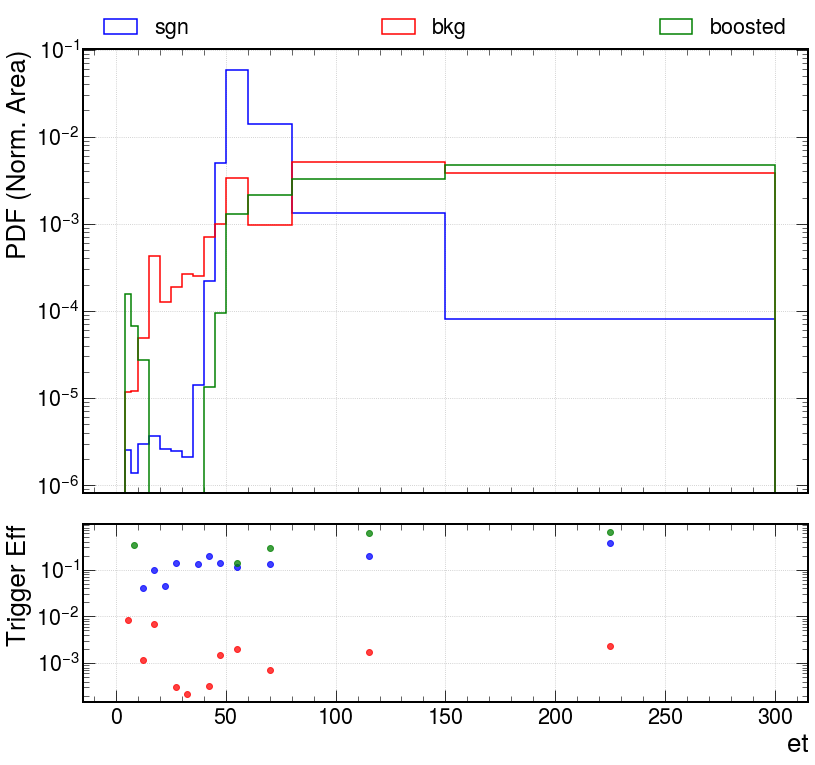

<Figure size 720x720 with 0 Axes>

In [96]:
data = [df_zee, df_boosted]

#variable = 'avgmu'
variable = 'et'
n_bins = 100 # meu padrão
# calculo do minino dos minimos e do maximo dos maximos
m_min = +999999999999
m_max = -999999999999
for idb in data:
    if idb[variable].min() < m_min:
        m_min = idb[variable].min()
    if idb[variable].max() > m_max:
        m_max = idb[variable].max()
bins = np.round(np.linspace(m_min, m_max, n_bins),2)
#bins =  [10, 20, 30, 40, 50, 60, 70] #avgmu
bins = [4.,7.,10.,15.,20.,25.,30.,35.,40.,45.,50.,60.,80.,150.,300.] # et_bins
    

offline_ref = 'tight'
target_variable = 'el_lh%s'%(offline_ref)
trg_op_point = 'loose'
ringer_version = 'v8'
ringer_variable = "nn_decision_%s_%s"%(trg_op_point,ringer_version)

ax  = plot_turn_on(df_sgn=df_sgn, df_bkg=df_bkg,df_boosted=df_boosted, 
                   variable=variable, target_variable=target_variable, 
                   ringer_variable=ringer_variable,bins=bins,verbose=True)
plt.show(ax)
plt.savefig('turnon_%s_offlineRef_%s_ringerOp_%s_ringerVersion_%s.pdf'%(variable,offline_ref,
                                                                        trg_op_point,ringer_version,),
            bbox_inches='tight',facecolor='white')
plt.savefig('turnon_%s_offlineRef_%s_ringerOp_%s_ringerVersion_%s.png'%(variable,offline_ref,
                                                                        trg_op_point,ringer_version,),
            bbox_inches='tight',facecolor='white', dpi=150)

In [87]:
df_boosted.query('4.0 < et/1000 <= 7.0')

,RunNumber,avgmu,trig_L2_cl_et,trig_L2_cl_eta,trig_L2_cl_phi,trig_L2_cl_reta,trig_L2_cl_ehad1,trig_L2_cl_eratio,trig_L2_cl_f1,trig_L2_cl_f3,...,trig_L2_el_cut_pt0to15,trig_L2_el_cut_pt15to20,trig_L2_el_cut_pt20to50,trig_L2_el_cut_pt50toInf,target,et_bin,eta_bin,nn_output_loose_v8,thr_loose_v8,nn_decision_loose_v8
860,300000,28.50,60315.199219,0.338982,2.167847,0.830550,11252.356445,0.372858,0.176484,0.028548,...,True,True,True,True,1.0,4,0,-6.039873,0.049125,0
1041,300000,48.50,102902.609375,-0.688547,2.640589,0.827043,37293.296875,0.180390,0.120360,0.021369,...,True,True,True,True,1.0,4,0,-4.501314,-0.191634,0
5367,284500,20.50,74222.460938,-0.269572,-0.643983,0.763092,5023.594727,0.098834,0.311649,0.007710,...,True,True,True,True,1.0,4,0,-6.512117,0.145429,0
27434,310000,41.50,766368.812500,-0.299807,1.881216,0.864334,85193.382812,0.352148,0.084194,0.014787,...,True,True,True,True,1.0,4,0,-4.893093,-0.107368,0
27642,310000,25.50,60242.207031,-0.741409,-2.881402,0.882643,5468.073242,0.312227,0.347426,0.005066,...,True,True,True,True,1.0,4,0,-6.201349,0.085239,0
30894,310000,19.50,136821.250000,0.570396,-2.844877,0.863437,95038.750000,0.031640,0.073647,0.023673,...,True,True,True,True,1.0,4,0,-5.821350,0.157467,0
34069,310000,26.49,665932.062500,0.151454,-1.982805,0.796892,193776.078125,0.065103,0.111190,0.012447,...,True,True,True,True,1.0,4,0,-6.168162,0.073321,0
